## Duet features soft labels inference
### Efthymios Tzinis

In [2]:
from matplotlib.pylab import *
import librosa
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Customize plots
rcParams['figure.figsize'] = (8,4)
rcParams['lines.linewidth'] = 1
rcParams['axes.axisbelow'] = True
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.family'] = 'Avenir Next LT Pro'
rcParams['font.weight'] = 400
rcParams['xtick.color'] = '#222222'
rcParams['ytick.color'] = '#222222'
rcParams['grid.color'] = '#dddddd'
rcParams['grid.linestyle'] = '-'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.titlesize'] = 11
rcParams['axes.titleweight'] = 600
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 400
rcParams['axes.linewidth'] = 0.5
rcParams['axes.edgecolor'] = [.25,.25,.25]
rcParams['axes.facecolor'] = '#FFFFFF00'
rcParams['figure.facecolor'] = '#FFFFFF00'

# Decent colormap
cdict = {	'red':   ((0.0,  1.0, 1.0), (1.0,  0.0, 0.0)),
	'green': ((0.0,  1.0, 1.0), (1.0,  .15, .15)),
		'blue':  ((0.0,  1.0, 1.0), (1.0,  0.4, 0.4)),
			'alpha': ((0.0,  0.0, 0.0), (1.0,  1.0, 1.0))}
register_cmap(name='InvBlueA', data=cdict)
rcParams['image.cmap'] = 'InvBlueA'

# Play a sound
def soundsc( s, r=16000, name=''):
    from IPython.display import display, Audio, HTML
    if name is '':
        display( Audio( s, rate=r))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + name + 
        '</td><td>' + Audio( s, rate=r)._repr_html_()[3:] + '</td></tr></table>'
        ))

# Clean up and redraw
def drawnow():
    from IPython.display import clear_output
    clear_output( wait=True)
    show()
    
# Equal and tight axis
def axisequaltight():
    gca().set_aspect('equal')
    gca().autoscale(tight=True)

44100
44100


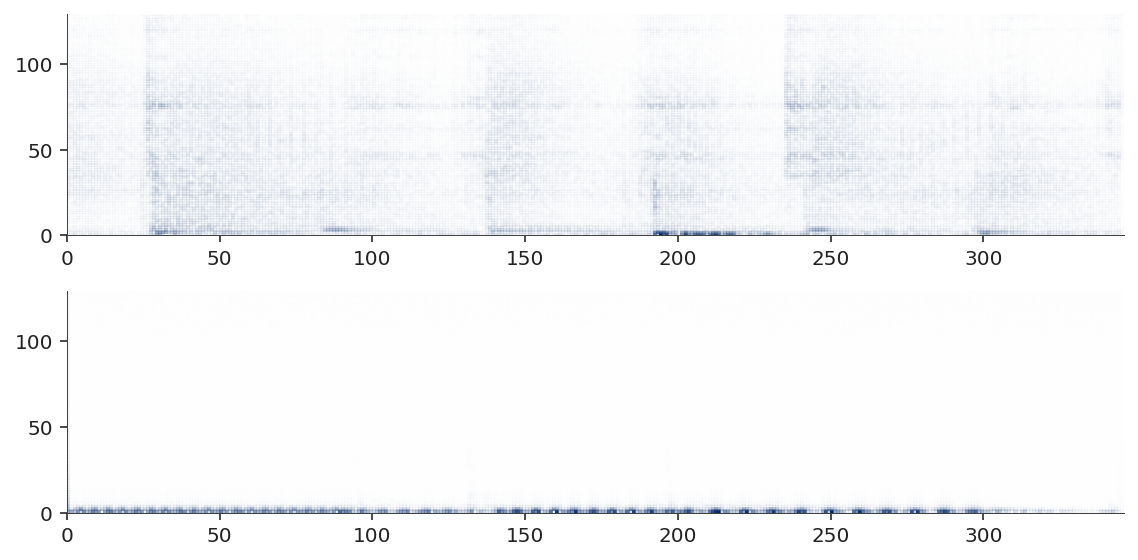

In [12]:
import librosa
from scipy.signal import stft, istft
s1_f="C:/Users/shaig/Documents/CS_Technion/2019_b/Deep Learning Project/DATA/DSD100subset/Sources/Dev/055 - Angels In Amplifiers - I'm Alright/drums.wav"
s2_f="C:/Users/shaig/Documents/CS_Technion/2019_b/Deep Learning Project/DATA/DSD100subset/Sources/Dev/055 - Angels In Amplifiers - I'm Alright/bass.wav"
s1,sr = librosa.core.load(  s1_f, sr=None, mono=True)

print(sr)
s2,sr = librosa.core.load( s2_f, sr=None, mono=True)

print(sr)
maximum = 44100
s1 = s1[:min(len(s1),len(s2),maximum)]
s2 = s2[:min(len(s1),len(s2), maximum)]

soundsc( s1, sr)
soundsc( s2, sr)

subplot( 2, 1, 1), pcolormesh( abs( stft( s1)[2])**.3)
subplot( 2, 1, 2), pcolormesh( abs( stft( s2)[2])**.3)
tight_layout()

In [14]:
# just in order to check if our loader returns the same
import os, sys, librosa, matplotlib# , plotly
import numpy as np 
from pprint import pprint 
from sklearn.cluster import KMeans
from sklearn.decomposition import FastICA
from matplotlib.pyplot import subplot, hist, tight_layout
from matplotlib.pylab import title
root_dir = '../../'
sys.path.insert(0, root_dir)
import spatial_two_mics.examples.mixture_example as me
import spatial_two_mics.utils.audio_mixture_constructor as mix_constructor
import spatial_two_mics.data_generator.source_position_generator as position_generator
import spatial_two_mics.labels_inference.tf_label_estimator as label_estimator
from spatial_two_mics.utils import robust_means_clustering as robust_kmeans
mixture_info = me.mixture_info_example()

random_positioner = position_generator.RandomCirclePositioner()
positions_info = random_positioner.get_sources_locations(2)
mixture_info['positions'] = positions_info

mixture_creator = mix_constructor.AudioMixtureConstructor(
        n_fft=1024, win_len=400, hop_len=200, mixture_duration=2.0,
        force_delays=[-1,1])

mixture_info['sources_ids'][0]['wav_path'] = s1_f
mixture_info['sources_ids'][1]['wav_path'] = s2_f
mixture_info
tf_representations = mixture_creator.construct_mixture(mixture_info)

# for i, source_tf in enumerate(tf_representations['sources_tf']):
#     subplot( 2, 1, i+1), pcolormesh( abs(source_tf)**.3)
# tight_layout()

C:\Users\shaig\Miniconda3\envs\dl-project\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


ParameterError: Invalid shape for monophonic audio: ndim=2, shape=(88199, 2)

In [ ]:
# Create the mixtures
s1 = tf_representations['sources_raw'][0]
s2 = tf_representations['sources_raw'][1]
a = 0.1
alphas = [a, 1. - a]
tau = 1
m1 = alphas[0]*s1[:-tau] + alphas[1]*s2[:-tau]
m2 = alphas[0]*s1[:-tau] + alphas[1]*s2[:-tau]

turbulence = 0.005
m1 = alphas[0]*s1[:-tau] + alphas[1]*s2[tau:]
m2 = (alphas[0]+turbulence)*s1[tau:] + (alphas[1]-turbulence)*s2[:-tau]

n_fft = 512
hop_length = 128
f1 = librosa.core.stft(m1, n_fft=n_fft, hop_length=hop_length, win_length=n_fft)
f2 = librosa.core.stft(m2, n_fft=n_fft, hop_length=hop_length, win_length=n_fft)
# f1 = stft(m1)[2]
# f2 = stft(m2)[2]

# r = log( f1 / (f2+1e-7))
r = f1 / (f2+1e-7)

# Log amplitude difference
a = abs( r)

# Phase difference, normalized by frequency
p = np.angle( r) / linspace( 1e-5, np.pi, f1.shape[0])[:,None]
# p = (np.angle(f1) - np.angle(f2))/ linspace( 1e-5, pi, f1.shape[0])[:,None]
# p = (np.angle(f1) - np.angle(f2)) / linspace( 1e-5, pi, f1.shape[0])[:,None]

# Show me
subplot( 2, 1, 1), hist( a.reshape( -1), linspace( -2, 2, 200)); title( 'Amplitude ratios')
subplot( 2, 1, 2), hist( p.reshape( -1), linspace( -pi, pi, 200)); title( 'Normalized phases')
# plot(), hist( p.reshape( -1), linspace( -pi, pi, 200)); title( 'Normalized phases')
tight_layout()


In [ ]:

hist( p.reshape( -1), linspace( -pi, pi, 200)); title( 'Normalized phases')
plt.show()

In [ ]:
# Plotly Functions 
import plotly
import plotly.tools as tls
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

def plot_tf_representation(tf, for_title = '', fs=16000, duration=2.0, log_scale=False):
    freq_max, time_max = tf.shape
    bins = np.arange(time_max)
    bins = (duration * bins) / time_max 
    freqs = np.arange(freq_max)
    freqs = (freqs * fs) / (2.0 * freq_max) 
    trace = [go.Heatmap(
        x= bins,
        y= freqs,
#         z= 10*np.log10(Pxx),
        z = 10*np.log10(tf) if log_scale else tf,
        colorscale='Jet',
        )]
    layout = go.Layout(
        title = 'Spectrogram '+for_title,
        yaxis = dict(title = 'Frequency'), # x-axis label
        xaxis = dict(title = 'Time'), # y-axis label
        )
    fig = dict(data=trace, layout=layout)
    plotly.offline.iplot(fig, filename=for_title)

In [ ]:
# let's check how these features go compared to the ground truth mask 
ground_truth_estimator = label_estimator.TFMaskEstimator(
                             inference_method='Ground_truth') 
tf_representations['amplitudes'] = alphas 
tf_representations['sources_tf'] = [librosa.core.stft(s1[:-tau], n_fft=n_fft, hop_length=hop_length, win_length=n_fft), 
                                    librosa.core.stft(s2[tau:], n_fft=n_fft, hop_length=hop_length, win_length=n_fft)]
gt_labels = ground_truth_estimator.infer_mixture_labels(tf_representations)
plot_tf_representation(gt_labels, for_title = 'Ground Truth Mask', log_scale=False)

In [ ]:
# now perform the analysis for duet soft labeling
phase_dif = p 
n_sources = len(tf_representations['sources_tf'])
d_feature = np.reshape(phase_dif, (np.product(phase_dif.shape), 1))

clusters = 4
r_kmeans = robust_kmeans.RobustKmeans(n_true_clusters=2, n_used_clusters=4)
# kmeans = KMeans(n_clusters=clusters, random_state=7).fit(d_feature)
d_labels = r_kmeans.fit(d_feature)
d_feature_mask = np.reshape(d_labels, phase_dif.shape)
plot_tf_representation(d_feature_mask, for_title = ' Phase Diff only using Robust 4-means => 2 clusters', log_scale=False)

In [ ]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice 

attenuation = abs(r)
smoothed_attenuation = attenuation - (1. / attenuation)
smoothed_attenuation_feature = np.reshape(smoothed_attenuation, (np.product(smoothed_attenuation.shape), 1))
duet_features = np.concatenate((d_feature, smoothed_attenuation_feature), axis=1)

r_kmeans = robust_kmeans.RobustKmeans(n_true_clusters=2, n_used_clusters=5)
# kmeans = KMeans(n_clusters=clusters, random_state=7).fit(d_feature)
duet_labels = r_kmeans.fit(duet_features)
duet_mask = np.reshape(duet_labels, phase_dif.shape)
plot_tf_representation(duet_mask, for_title = ' DUET features using Robust 4-means => 2 clusters', log_scale=False)

In [ ]:
# check the duet features how they scatter 
gt_flatten = gt_labels.reshape(1,-1)
xyl = np.concatenate((duet_features, gt_flatten.T), axis=1) 

# clip high norm values and also random sampling
xyl = np.clip(xyl, -10., 10.)
rand_ind = np.random.choice(np.arange(xyl.shape[0]), size=3000, replace=False)
xyl = xyl[rand_ind, :]


N = xyl.shape[0]
pred0 = xyl[xyl[:,2]==0]
pred1 = xyl[xyl[:,2]==1]

title = 'Scatter of DUET features for Ground Truth Masking'

trace0 = go.Scatter(
    x = pred0[:,0],
    y = pred0[:,1],
    name = 'Source 1',
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

trace1 = go.Scatter(
    x = pred1[:,0],
    y = pred1[:,1],
    name = 'Source 2',
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'rgba(255, 182, 193, .9)',
        line = dict(
            width = 2,
        )
    )
)

data = [trace0, trace1]

layout = dict(title = 'Styled Scatter',
              yaxis = dict(zeroline = False, title='Attenuation'),
              xaxis = dict(zeroline = False, title = 'Phase Difference')
             )

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename=title)


# duet_features = d_feature

In [ ]:
# now run multiple clustering algorithms in order to see how it goes:
gmm = mixture.GaussianMixture(
      n_components=n_sources, covariance_type='full')
spectral = cluster.SpectralClustering(
        n_clusters=n_sources, eigen_solver='arpack',
        affinity="nearest_neighbors")
kmeans = KMeans(n_clusters=n_sources, random_state=0)

clustering_algorithms = (
        ('Kmeans', kmeans),
        ('SpectralClustering', spectral),
        ('GaussianMixture', gmm)
    )

In [ ]:
def get_mask_representation(mask, gt, for_title, fs=16000., 
                            log_scale=False):
    freq_max, time_max = mask.shape
    bins = np.arange(time_max)
    bins = (duration * bins) / time_max 
    freqs = np.arange(freq_max)
    freqs = (freqs * fs) / (2.0 * freq_max) 
    trace = [go.Heatmap(
        x= bins,
        y= freqs,
        z = 10*np.log10(mask) if log_scale else mask,
        colorscale='Jet',
        )]
#     also plot the difference from the true mask 
    trace2 = [go.Heatmap(
        x= bins,
        y= freqs,
        z = abs(mask-gt),
        colorscale='Jet',
        )]
    
    layout = go.Layout(
        title = for_title,
        yaxis = dict(title = 'Frequency'), # x-axis label
        xaxis = dict(title = 'Time'), # y-axis label
        )
    fig = dict(data=trace, layout=layout)
    plotly.offline.iplot(fig, filename=for_title)

In [ ]:
# X = duet_features
# plot_num = 1
# for name, algorithm in clustering_algorithms:
#     t0 = time.time()

#     # catch warnings related to kneighbors_graph
#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             "ignore",
#             message="the number of connected components of the " +
#             "connectivity matrix is [0-9]{1,2}" +
#             " > 1. Completing it to avoid stopping the tree early.",
#             category=UserWarning)
#         warnings.filterwarnings(
#             "ignore",
#             message="Graph is not fully connected, spectral embedding" +
#             " may not work as expected.",
#             category=UserWarning)
#         algorithm.fit(X)

#     t1 = time.time()
#     if hasattr(algorithm, 'labels_'):
#         y_pred = algorithm.labels_
#     else:
#         y_pred = algorithm.predict(X)
    
#     duet_mask = np.reshape(y_pred, phase_dif.shape)
#     title = 'Algorithm: {} run in {} seconds'.format(name, t1-t0 )
# #     plot_tf_representation(duet_mask, gt_labels, title, log_scale=False)
#     plot_tf_representation(duet_mask, for_title=title, log_scale=False)

In [ ]:
def bss_eval( sep, i, sources):
    # Current target
    from numpy import dot, linalg, log10
    min_len = min([len(sep), len(sources[i])])
    sources = sources[:,:min_len]
    sep = sep[:min_len]
    target = sources[i]

    # Target contribution
    s_target = target * dot( target, sep.T) / dot( target, target.T)

    # Interference contribution
    pse = dot( dot( sources, sep.T), \
    linalg.inv( dot( sources, sources.T))).T.dot( sources)
    e_interf = pse - s_target

    # Artifact contribution
    e_artif= sep - pse;

    # Interference + artifacts contribution
    e_total = e_interf + e_artif;

    # Computation of the log energy ratios
    sdr = 10*log10( sum( s_target**2) / sum( e_total**2));
    sir = 10*log10( sum( s_target**2) / sum( e_interf**2));
    sar = 10*log10( sum( (s_target + e_interf)**2) / sum( e_artif**2));

    return (sdr, sir, sar)

In [ ]:
# try to evaluate the reconstructed signals 
clusters = 3 
d_feature = np.reshape(phase_dif, (np.product(phase_dif.shape), 1))

r_kmeans = robust_kmeans.RobustKmeans(n_true_clusters=2, n_used_clusters=4)
# kmeans = KMeans(n_clusters=clusters, random_state=7).fit(d_feature)
duet_labels = r_kmeans.fit(d_feature)
duet_mask = np.reshape(duet_labels, phase_dif.shape)
gt_mask = gt_labels 

for i in np.arange(n_sources):
    d_stft = abs(f1)*(duet_mask==i).reshape(f1.shape)
    gt_stft = abs(f1)*(gt_mask==i).reshape(f1.shape)
    plot_tf_representation(d_stft, for_title='Duet reconstructed STFT')
    plot_tf_representation(gt_stft, for_title='Ground truth reconstructed STFT')

In [ ]:
stft_rec = []
stft_gt = []

sources = np.array([s1, s2])
fs = 16000
for i in np.arange(n_sources):
    d_stft = f1*(duet_mask==i).reshape(f1.shape)
    gt_stft = f1*(gt_mask==i).reshape(f1.shape)
    
    
    d_s_rec = librosa.core.istft( d_stft, 
                                 hop_length=hop_length, win_length=n_fft)
    gt_s_rec = librosa.core.istft( gt_stft, 
                                 hop_length=hop_length, win_length=n_fft)

    soundsc( d_s_rec, fs, 'Librosa Duet Reconstructed Signal for Source: {}'.format(i))
    (sdr, sir, sar) = bss_eval( d_s_rec, 0, sources)
    print((sdr, sir, sar))
    (sdr, sir, sar) = bss_eval( d_s_rec, 1, sources)
    print((sdr, sir, sar))
    
    soundsc( gt_s_rec, fs, 'Ground Truth Reconstructed Signal for Source: {}'.format(i))
    (sdr, sir, sar) = bss_eval( gt_s_rec, 0, sources)
    print((sdr, sir, sar))
    (sdr, sir, sar) = bss_eval( gt_s_rec, 1, sources)
    print((sdr, sir, sar))